# Building an Interpretable Expected Goals (xG) Model
* Author: Oliver Mueller
* Date: 2024-02-15

In [30]:
import warnings
warnings.filterwarnings("ignore")

import datetime
import numpy as np
import pandas as pd
import seaborn as sns
from tqdm import tqdm
import matplotlib.pyplot as plt
from statsbombpy import sb
import math
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve, roc_auc_score, auc, RocCurveDisplay
from sklearn.metrics import classification_report
import statsmodels.api as sm
import statsmodels.formula.api as smf

## Load data

Using the `statsbombpy`package, we will query the StatsBomb API for all events of the Bundesliga season 2015/16.  

In [2]:
grouped_events = sb.competition_events(
    country="Germany",
    division= "1. Bundesliga",
    season="2015/2016",
    gender="male",
    split=True
)

/Users/oliver/miniconda3/envs/prodok/lib/python3.12/site-packages/statsbombpy/api_client.py:21: NoAuthWarning: credentials were not supplied. open data access only
  warnings.warn(
/Users/oliver/miniconda3/envs/prodok/lib/python3.12/site-packages/statsbombpy/api_client.py:21: NoAuthWarning: credentials were not supplied. open data access only
  warnings.warn(
/Users/oliver/miniconda3/envs/prodok/lib/python3.12/site-packages/statsbombpy/api_client.py:21: NoAuthWarning: credentials were not supplied. open data access only
  warnings.warn(
/Users/oliver/miniconda3/envs/prodok/lib/python3.12/site-packages/statsbombpy/api_client.py:21: NoAuthWarning: credentials were not supplied. open data access only
  warnings.warn(
/Users/oliver/miniconda3/envs/prodok/lib/python3.12/site-packages/statsbombpy/api_client.py:21: NoAuthWarning: credentials were not supplied. open data access only
  warnings.warn(
/Users/oliver/miniconda3/envs/prodok/lib/python3.12/site-packages/statsbombpy/api_client.py:21:

What types of events do we have?

In [3]:
grouped_events.keys()

dict_keys(['starting_xis', 'half_starts', 'passes', 'ball_receipts', 'carrys', 'pressures', 'blocks', 'ball_recoverys', 'miscontrols', 'interceptions', 'foul_committeds', 'foul_wons', 'shots', 'goal_keepers', 'duels', 'dribbles', 'dribbled_pasts', 'clearances', 'dispossesseds', 'tactical_shifts', 'injury_stoppages', 'player_offs', 'player_ons', 'half_ends', 'substitutions', 'shields', 'own_goal_againsts', 'own_goal_fors', '50/50s', 'referee_ball_drops', 'bad_behaviours', 'offsides', 'errors'])

Extract and explore the shots.

In [4]:
shots = grouped_events["shots"]

In [5]:
shots.shape

(7831, 40)

In [6]:
shots.head()

,id,index,period,timestamp,minute,second,type,possession,possession_team,play_pattern,...,shot_aerial_won,shot_one_on_one,shot_deflected,out,shot_open_goal,shot_redirect,shot_saved_off_target,shot_saved_to_post,off_camera,shot_follows_dribble
0,ba46e9d6-e828-4599-952c-39c1f7d22659,263,1,00:04:21.052,4,21,Shot,7,Hoffenheim,Regular Play,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,85d67225-30fb-47c8-b478-cf568941a164,353,1,00:06:27.395,6,27,Shot,11,Schalke 04,From Throw In,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,adac17d3-5e67-4e8c-b482-4bae2f36e06e,410,1,00:08:16.762,8,16,Shot,15,Hoffenheim,From Throw In,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,abffd193-62bc-4c8d-8636-1e3f0f0ebbe5,624,1,00:13:55.721,13,55,Shot,27,Schalke 04,From Counter,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,d9cea903-f92a-40e1-a393-1a849d83f157,749,1,00:17:16.953,17,16,Shot,33,Schalke 04,Regular Play,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [7]:
shots.columns

Index(['id', 'index', 'period', 'timestamp', 'minute', 'second', 'type',
       'possession', 'possession_team', 'play_pattern', 'team', 'player',
       'position', 'location', 'duration', 'related_events', 'match_id',
       'shot_statsbomb_xg', 'shot_end_location', 'shot_key_pass_id',
       'shot_type', 'shot_outcome', 'shot_first_time', 'shot_technique',
       'shot_body_part', 'shot_freeze_frame', 'possession_team_id', 'team_id',
       'player_id', 'under_pressure', 'shot_aerial_won', 'shot_one_on_one',
       'shot_deflected', 'out', 'shot_open_goal', 'shot_redirect',
       'shot_saved_off_target', 'shot_saved_to_post', 'off_camera',
       'shot_follows_dribble'],
      dtype='object')

In [8]:
shots.iloc[0]

id                                    ba46e9d6-e828-4599-952c-39c1f7d22659
index                                                                  263
period                                                                   1
timestamp                                                     00:04:21.052
minute                                                                   4
second                                                                  21
type                                                                  Shot
possession                                                               7
possession_team                                                 Hoffenheim
play_pattern                                                  Regular Play
team                                                            Hoffenheim
player                                                   Tarik Elyounoussi
position                                                    Left Wing Back
location                 

In [9]:
shots.iloc[0]["shot_freeze_frame"]

[{'location': [115.7, 50.0],
  'player': {'id': 3510, 'name': 'Sead Kolašinac'},
  'position': {'id': 6, 'name': 'Left Back'},
  'teammate': False},
 {'location': [113.2, 39.3],
  'player': {'id': 3502, 'name': 'Joël Andre Job Matip'},
  'position': {'id': 3, 'name': 'Right Center Back'},
  'teammate': False},
 {'location': [119.0, 42.5],
  'player': {'id': 16534, 'name': 'Roman Neustädter'},
  'position': {'id': 5, 'name': 'Left Center Back'},
  'teammate': False},
 {'location': [111.6, 34.8],
  'player': {'id': 7016, 'name': 'Benedikt Höwedes'},
  'position': {'id': 2, 'name': 'Right Back'},
  'teammate': False},
 {'location': [96.7, 36.3],
  'player': {'id': 6039, 'name': 'Sebastian Rudy'},
  'position': {'id': 11, 'name': 'Left Defensive Midfield'},
  'teammate': True},
 {'location': [104.0, 43.8],
  'player': {'id': 8556, 'name': 'Pirmin Schwegler'},
  'position': {'id': 9, 'name': 'Right Defensive Midfield'},
  'teammate': True},
 {'location': [109.2, 37.7],
  'player': {'id': 54

In [10]:
shots["shot_outcome"].value_counts()

shot_outcome
Off T               2452
Saved               1961
Blocked             1820
Goal                 837
Wayward              550
Post                 160
Saved to Post         35
Saved Off Target      16
Name: count, dtype: int64

## Train classifier

Construct the label.

In [11]:
shots["is_goal"] = shots["shot_outcome"].apply(lambda x: 1 if x == "Goal" else 0)

Engineer some features.

In [12]:
shots["location_x"] = shots["location"].apply(lambda x: float(x[0]))
shots["location_y"] = shots["location"].apply(lambda x: float(x[1]))

In [13]:
shots["distance_to_goal"] = shots.apply(lambda row: math.dist(row["location"], [120.0, 40.0]), axis=1)

In [14]:
def angle_between(a, b, c):
    ang = math.degrees(math.atan2(c[1]-b[1], c[0]-b[0]) - math.atan2(a[1]-b[1], a[0]-b[0]))
    return ang + 360 if ang < 0 else ang

In [15]:
shots["angle_to_goal"] = shots.apply(lambda row: angle_between(row["location"], [120.0, 44.0], [120.0, 36.0]), axis=1)

In [16]:
shots.iloc[0]

id                                    ba46e9d6-e828-4599-952c-39c1f7d22659
index                                                                  263
period                                                                   1
timestamp                                                     00:04:21.052
minute                                                                   4
second                                                                  21
type                                                                  Shot
possession                                                               7
possession_team                                                 Hoffenheim
play_pattern                                                  Regular Play
team                                                            Hoffenheim
player                                                   Tarik Elyounoussi
position                                                    Left Wing Back
location                 

Make a train-test split.

In [17]:
train, test = train_test_split(shots, test_size=0.2, random_state=42)

Train a logistic regression model.

In [46]:
model_logit = smf.logit(formula='is_goal ~ location_x + location_y + distance_to_goal', data=train)
model_logit = model_logit.fit()

Optimization terminated successfully.
         Current function value: 0.299627
         Iterations 7


In [47]:
print(model_logit.summary())

                           Logit Regression Results                           
Dep. Variable:                is_goal   No. Observations:                 6264
Model:                          Logit   Df Residuals:                     6260
Method:                           MLE   Df Model:                            3
Date:                Fri, 16 Feb 2024   Pseudo R-squ.:                  0.1217
Time:                        15:21:19   Log-Likelihood:                -1876.9
converged:                       True   LL-Null:                       -2136.8
Covariance Type:            nonrobust   LLR p-value:                2.288e-112
                       coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------
Intercept           10.6105      2.328      4.558      0.000       6.048      15.173
location_x          -0.0903      0.019     -4.682      0.000      -0.128      -0.052
location_y           0.0066 

Evaluate the model.

In [48]:
pred_proba = model_logit.predict(test)

In [49]:
roc_auc_score(test["is_goal"], pred_proba)

0.7545068928950159

## Visualize model

We create a 2D grid of x/y pitch coordinates from (0, 0) to (120, 80). We also calculate distance and angle to the goal for each cell.

In [58]:
simulated_positions = pd.DataFrame()
simulated_positions["location_x"] = np.tile(np.arange(0, 121, 1), 81)
simulated_positions["location_y"] = np.repeat(np.arange(0, 81, 1), 121)
simulated_positions["distance_to_goal"] = simulated_positions.apply(lambda row: math.dist([row["location_x"], row["location_y"]], [120.0, 40.0]), axis=1)

In [59]:
simulated_positions.head()

,location_x,location_y,distance_to_goal
0,0,0,126.491106
1,1,0,125.542821
2,2,0,124.595345
3,3,0,123.648696
4,4,0,122.702893


In [60]:
simulated_positions.tail()

,location_x,location_y,distance_to_goal
9796,116,80,40.199502
9797,117,80,40.112342
9798,118,80,40.049969
9799,119,80,40.012498
9800,120,80,40.000000


We predict the probability of a goal for each test observation.

In [61]:
pred_proba = model_logit.predict(simulated_positions)
simulated_positions["xG"] = pred_proba

In [65]:
simulated_positions.head()

,location_x,location_y,distance_to_goal,xG
0,0,0,126.491106,6.795204e-08
1,1,0,125.542821,7.608087e-08
2,2,0,124.595345,8.516735e-08
3,3,0,123.648696,9.532215e-08
4,4,0,122.702893,1.066684e-07


The highlight is a visualization of our xG model.

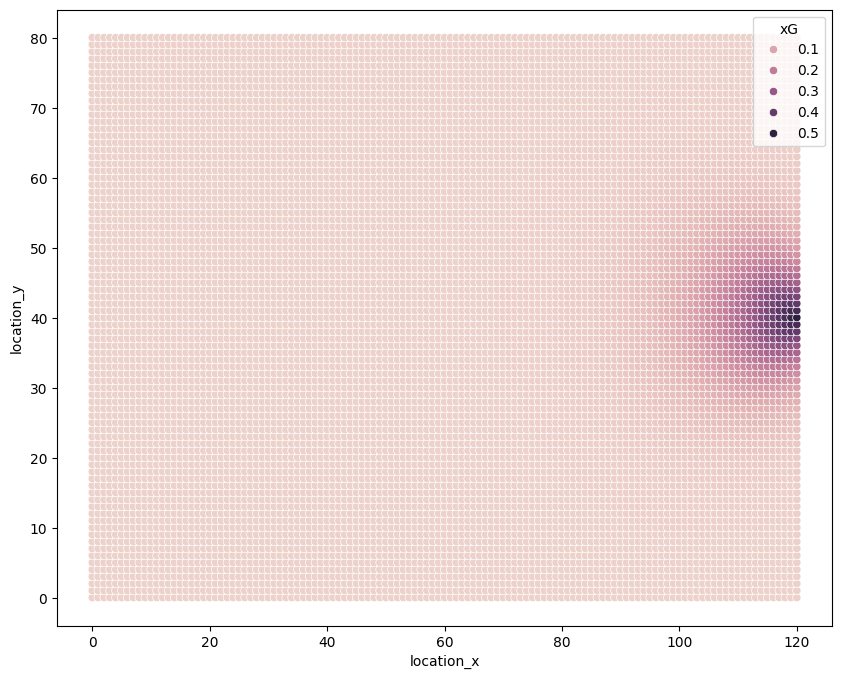

In [66]:
plt.figure(figsize=(10, 8))
sns.scatterplot(data=simulated_positions, x="location_x", y="location_y", hue="xG")
plt.show()
